## Importing and Useful Functions

In [1]:
import os
import sys
import copy
import logging
import math
from collections import defaultdict

import numpy as np
import pandas as pd
import scipy

from sklearn.ensemble import (
    RandomForestRegressor,
    RandomForestClassifier,
    BaggingRegressor,
)
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier, plot_tree
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score, KFold, GridSearchCV
from sklearn.calibration import CalibratedClassifierCV
from sklearn.inspection import permutation_importance
from scipy.cluster import hierarchy

from IPython.display import display
from matplotlib import pyplot as plt

In [2]:
path_to_repo = os.path.dirname(os.getcwd())
sys.path.insert(0, os.path.join(path_to_repo, "src"))

In [3]:
from mlpcourse.utils import *

In [4]:
def split_vals(df, n):
    return df[:n].copy(), df[n:].copy()


def rmse(y_gold, y_pred):
    return math.sqrt(((y_gold - y_pred) ** 2).mean())


def print_score(m, X_train, y_train, X_valid, y_valid):
    print(f"RMSE on train set: {rmse(y_train, m.predict(X_train)):.4f}")
    print(f"RMSE on valid set: {rmse(y_valid, m.predict(X_valid)):.4f}")
    print(f"R^2 on train set: {m.score(X_train, y_train):.4f}")
    print(f"R^2 on valid set: {m.score(X_valid, y_valid):.4f}")
    return


def rf_feat_importance(model, df):
    feat_importance = pd.DataFrame(
        {
            "cols": df.columns,
            "imp": model.feature_importances_,
        }
    ).sort_values("imp", ascending=False)
    return feat_importance


def remove_redundant_features(df, threshold=0.2):
    # Remove constant columns
    df = df.loc[:, (df != df.iloc[0]).any()]

    # Calculate Spearman correlation matrix
    corr = np.round(scipy.stats.spearmanr(df).correlation, 4)
    if np.any(np.isnan(corr)):
        raise ValueError(
            "Correlation matrix contains NaN values. Please check your data."
        )

    corr_condensed = hierarchy.distance.squareform(1 - corr)
    corr_linkage = hierarchy.linkage(corr_condensed, method="average")
    cluster_ids = hierarchy.fcluster(corr_linkage, threshold, criterion="distance")
    cluster_id_to_feature_ids = defaultdict(list)
    for idx, cluster_id in enumerate(cluster_ids):
        cluster_id_to_feature_ids[cluster_id].append(idx)

    selected_features = [df.columns[v[0]] for v in cluster_id_to_feature_ids.values()]
    return df[selected_features]

## Data Preparation

In [5]:
path_to_dataset = os.path.join(
    os.path.dirname(os.getcwd()), "data", "bulldozers", "bulldozers-raw"
)

df_raw = pd.read_feather(path_to_dataset)

df, y, nas = proc_df(df_raw, "SalePrice")

n_total = len(df)
n_valid = 12000
n_train = n_total - n_valid

X_train, X_valid = split_vals(df, n_train)
y_train, y_valid = split_vals(y, n_train)

## First Training

In [6]:
model = RandomForestRegressor(
    n_estimators=50,
    min_samples_split=10,
    max_features=0.5,
    n_jobs=-1,
    random_state=42,
    bootstrap=True,
    oob_score=True,
    max_samples=0.75,
)

model.fit(X_train, y_train)

RandomForestRegressor(max_features=0.5, max_samples=0.75, min_samples_split=10,
                      n_estimators=50, n_jobs=-1, oob_score=True,
                      random_state=42)

In [7]:
print_score(model, X_train, y_train, X_valid, y_valid)

RMSE on train set: 0.1324
RMSE on valid set: 0.2295
R^2 on train set: 0.9633
R^2 on valid set: 0.9059


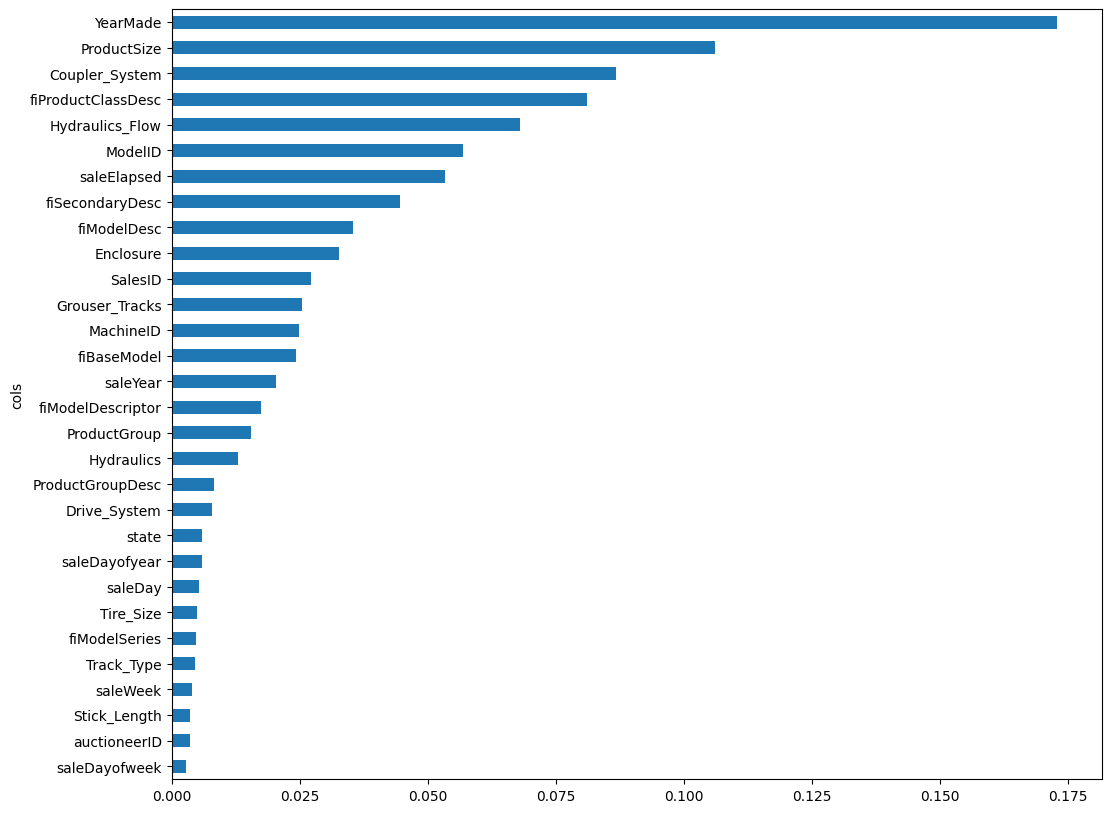

In [8]:
feat_importance = rf_feat_importance(model, X_train)
feat_importance[:30].plot(
    "cols", "imp", "barh", figsize=(12, 10), legend=False
).invert_yaxis()

In [12]:
result = permutation_importance(
    model, X_valid, y_valid, n_repeats=10, random_state=42, n_jobs=-1
)
sorted_idx = result.importances_mean.argsort()

/tmp/ipykernel_1268/1781223240.py:2: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(


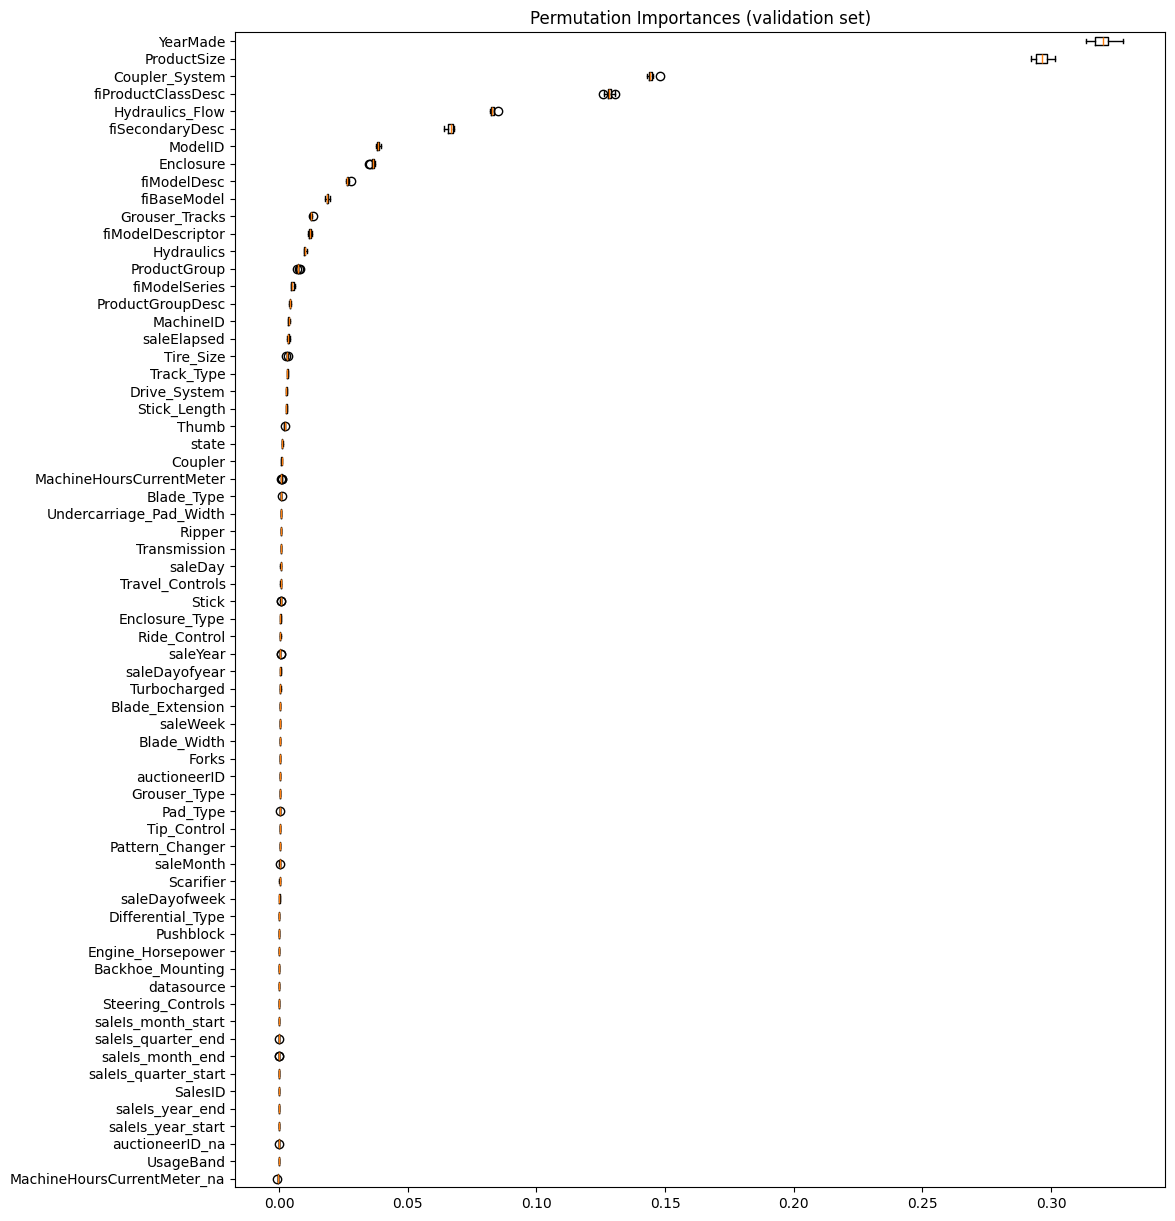

In [13]:
fig, ax = plt.subplots(figsize=(12, 15))
ax.boxplot(
    result.importances[sorted_idx].T, vert=False, labels=X_valid.columns[sorted_idx]
)
ax.set_title("Permutation Importances (validation set)")
plt.show()

## Remove Redundant Features

In [ ]:
df_reduced = remove_redundant_features(df)
X_train_reduced, X_valid_reduced = split_vals(df_reduced, n_train)

model.fit(X_train_reduced, y_train)

In [ ]:
print_score(model, X_train_reduced, y_train, X_valid_reduced, y_valid)

In [ ]:
result = permutation_importance(
    model, X_valid_reduced, y_valid, n_repeats=10, random_state=42, n_jobs=-1
)
sorted_idx = result.importances_mean.argsort()

In [ ]:
fig, ax = plt.subplots(figsize=(12, 15))
ax.boxplot(
    result.importances[sorted_idx].T,
    vert=False,
    labels=X_valid_reduced.columns[sorted_idx],
)
ax.set_title("Permutation Importances (after feature reduction)")
plt.show()

In [ ]:
bool_filter = result.importances_mean > np.percentile(result.importances_mean, 45)
to_keep = df_reduced.columns[bool_filter]

df_keep = df_reduced[to_keep].copy()

X_train_keep, X_valid_keep = split_vals(df_keep, n_train)
y_train, y_valid = split_vals(y, n_train)

df_keep

In [ ]:
model = RandomForestRegressor(
    n_estimators=60,
    max_depth=45,
    min_samples_split=10,
    max_features=0.51,  # default = 'auto'/None
    n_jobs=-1,
    random_state=42,
    bootstrap=True,
    oob_score=True,  # default = False,
    max_samples=0.75,  # default = None,
)

model.fit(X_train_keep, y_train)

In [ ]:
print_score(model, X_train_keep, y_train, X_valid_keep, y_valid)